# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [13]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


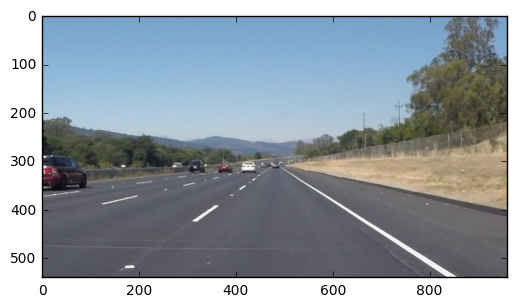

In [14]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [195]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    image_shape = img.shape
    max_x = image_shape[1]
    max_y = image_shape[0]
    #print("max_x = " + repr(max_x) + " max_y = " + repr(max_y))
    left_x1 = 0
    left_y1 = max_y
    right_x1 = max_x
    right_y1 = max_y
    left_x2 = max_x
    left_y2 = 0
    right_x2 = 0
    right_y2= 0
    for line in lines:
        # print ("Line: "+ repr(line))
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            if slope > 0.2 and slope < 1.4:
                # Process right line
                if not is_good_right_line2(x1, x2, int(max_x * 0.48)):
                    print("Bad right line: slope: " + repr(slope) + " : "+ repr(x1) + ", " + repr(y1) + " to " + repr(x2) + ", " + repr(y2))
                    break
                #print("right slope " + repr(x1) + ", " + repr(y1) + " to " + repr(x2) + ", " + repr(y2))
                right_x1 = min(right_x1, x1, x2)
                right_y1 = min(right_y1, y1, y2)
                right_x2 = max(right_x2, x1, x2)
                right_y2 = max(right_y2, y1, y2)
            elif slope < -0.2 and slope > -1.4:
                # Process left line
                #if not is_good_left_line(x1, x2, min(right_x1, right_x2)):
                x_limit = int(max_x * 0.52)
                if not is_good_left_line2(x1, x2, x_limit):
                    print("Bad left line: slope:" + repr(slope) + "/" + repr(x_limit) + " : " + repr(x1) + ", " + repr(y1) + " to " + repr(x2) + ", " + repr(y2))
                    break
                #print("left slope " + repr(x1) + ", " + repr(y1) + " to " + repr(x2) + ", " + repr(y2))
                left_x1 = max(left_x1, x1, x2)
                left_y1 = min(left_y1, y1, y2)
                left_x2 = min(left_x2, x1, x2)
                left_y2 = max(left_y2, y1, y2)
            #print("Slope = " + repr(slope))
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    min_y = min(left_y1, right_y1)
    max_y = max(left_y2, right_y2)
    left_y1, left_x1, left_y2, left_x2 = extrapolate_line(left_y1, left_x1, left_y2, left_x2, min_y, max_y)
    right_y1, right_x1, right_y2, right_x2 = extrapolate_line(right_y1, right_x1, right_y2, right_x2, min_y, max_y)
    cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, 4*thickness)
    cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, 4*thickness)
    
def is_good_right_line2(right_x1, right_x2, x_limit):
    return right_x1 > x_limit or right_x2 > x_limit

def is_good_right_line(right_x1, right_x2, left_x):
    return right_x1 > left_x and right_x2 > left_x

def is_good_left_line2(left_x1, left_x2, right_x):
    return left_x1 < right_x or left_x2 < right_x

def is_good_left_line(left_x1, left_x2, right_x):
    return left_x1 < right_x and left_x2 < right_x
    
def extrapolate_line(low_y, low_x, high_y, high_x, min_y, max_y):
    """
     This routine extrapolates the given line so that both low_y and high_y hit min_y  and max_y respectively.
     low_x is the x value corresponding to the low_y where low_y < high_y.
     Similarly high_x is the x value corresponding to high_y such that high_y > low_y.
    """
    slope = ((high_y - low_y)/ (high_x - low_x))
    if (high_y < max_y):
        high_y = max_y
        high_x = int((high_y - low_y + slope*low_x) / slope)
    if (low_y > min_y):
        low_y = min_y
        low_x = int((low_y - high_y + slope * high_x) / slope)
    return low_y, low_x, high_y, high_x

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [16]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

max_x = 540 max_y = 960
Bad left line: slope:-0.81818181818181823/324 : 383, 382 to 416, 355
Bad left line: slope:-0.86842105263157898/324 : 418, 360 to 456, 327


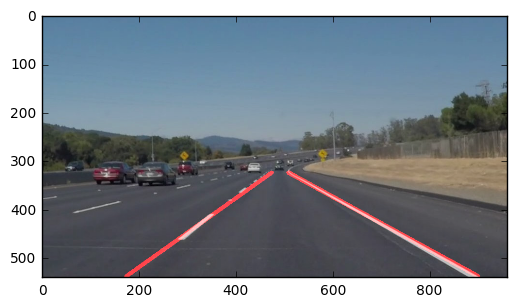

In [187]:


# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.


def draw_lane_lines(image):
    image_gray = grayscale(image)
    kernel_size = 5
    image_blur = gaussian_blur(image_gray, kernel_size)
    image_canny = canny(image_blur, 80, 150)
    
    # Apply edge trimming.
    imshape = image_canny.shape
    left_bottom = (0.03 * imshape[1], imshape[0])
    left_top = (0.45 * imshape[1], 0.60 * imshape[0])
    right_top = ( 0.55 * imshape[1], 0.60 * imshape[0])
    right_bottom = (0.97 * imshape[1], imshape[0])
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    image_trimmed = region_of_interest(image_canny, vertices)
    
    # Apply hough transform.
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 4     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    image_hough = hough_lines(image_trimmed, rho, theta, threshold, min_line_length, max_line_gap)
    return weighted_img(image_hough, image)
    #return image_hough

def draw_lane_lines_for_filename(image_filename):
    image = mpimg.imread(image_filename)
    return draw_lane_lines(image)
    
#for i in os.listdir("test_images/"):
#    print ("File: " + repr(i))
#    draw_lane_lines_for_filename("test_images/" + i)
    
result = draw_lane_lines_for_filename("test_images/solidWhiteCurve.jpg")
plt.imshow(result)

max_x = 960 max_y = 540


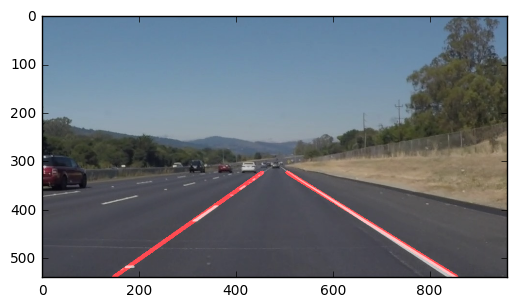

In [189]:

result2 = draw_lane_lines_for_filename("test_images/solidWhiteRight.jpg")
plt.imshow(result2)


Bad left line: slope:-0.71969696969696972 : 324, 420 to 456, 325
Bad left line: slope:-0.77142857142857146 : 415, 360 to 450, 333


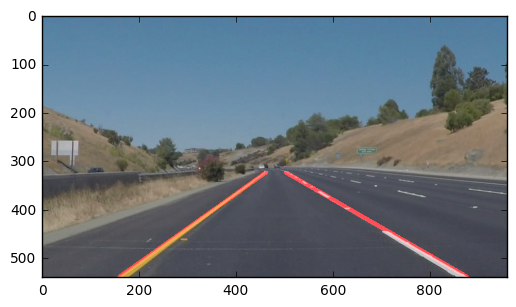

In [176]:
result4 = draw_lane_lines_for_filename("test_images/solidYellowCurve2.jpg")
plt.imshow(result4)

Bad left line: slope:-0.77215189873417722 : 334, 421 to 413, 360
Bad left line: slope:-0.68627450980392157 : 405, 361 to 456, 326
Bad left line: slope:-0.78125 : 377, 389 to 441, 339
Bad left line: slope:-0.71875 : 424, 347 to 456, 324
Bad left line: slope:-0.78048780487804881 : 331, 423 to 372, 391


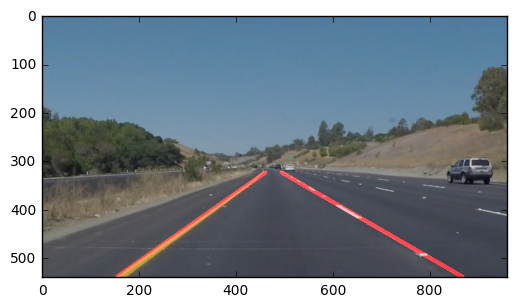

In [175]:
result3 = draw_lane_lines_for_filename("test_images/solidYellowCurve.jpg")
plt.imshow(result3)

Bad left line: slope:-0.77380952380952384 : 368, 389 to 452, 324
Bad left line: slope:-0.82857142857142863 : 328, 420 to 363, 391
Bad left line: slope:-0.79411764705882348 : 419, 351 to 453, 324
Bad left line: slope:-0.68292682926829273 : 341, 400 to 382, 372


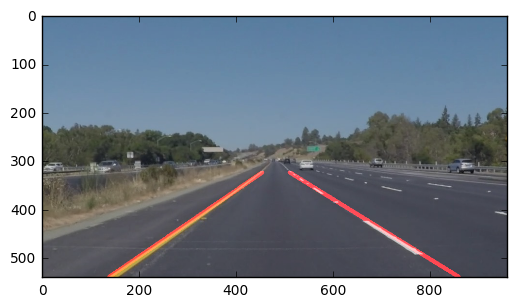

In [174]:
result4 = draw_lane_lines_for_filename("test_images/solidYellowLeft.jpg")
plt.imshow(result4)

Bad left line: slope:-0.74736842105263157 : 369, 395 to 464, 324
Bad left line: slope:-0.75362318840579712 : 389, 381 to 458, 329
Bad left line: slope:-0.375 : 392, 345 to 448, 324
Bad left line: slope:-0.80645161290322576 : 430, 356 to 461, 331
Bad left line: slope:-0.39393939393939392 : 396, 343 to 429, 330


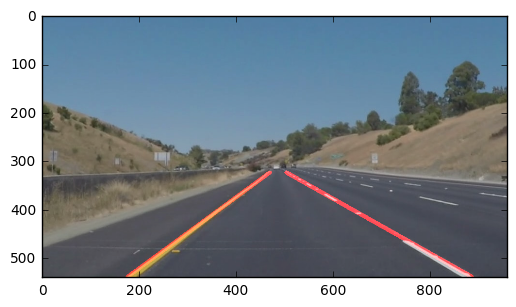

In [178]:
result5 = draw_lane_lines_for_filename("test_images/whiteCarLaneSwitch.jpg")
plt.imshow(result5)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [72]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [179]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = draw_lane_lines(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [190]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

max_x = 960 max_y = 540
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  6%|▌         | 13/222 [00:00<00:01, 123.66it/s]

max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540


 18%|█▊        | 41/222 [00:00<00:01, 127.96it/s]

max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540


 27%|██▋       | 60/222 [00:00<00:01, 104.09it/s]

max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540


 36%|███▌      | 80/222 [00:00<00:01, 99.07it/s]

max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540


 45%|████▌     | 101/222 [00:00<00:01, 97.87it/s]

max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540


 55%|█████▍    | 121/222 [00:01<00:01, 95.46it/s]

max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540


 64%|██████▎   | 141/222 [00:01<00:00, 93.61it/s]

max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540


 73%|███████▎  | 161/222 [00:01<00:00, 92.66it/s]

max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540


 82%|████████▏ | 181/222 [00:01<00:00, 92.89it/s]

max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540


 86%|████████▌ | 191/222 [00:01<00:00, 92.03it/s]

max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540


 91%|█████████ | 201/222 [00:02<00:00, 92.78it/s]

max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540


 95%|█████████▌| 211/222 [00:02<00:00, 92.60it/s]

max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540
max_x = 960 max_y = 540


100%|█████████▉| 221/222 [00:02<00:00, 93.37it/s]

max_x = 960 max_y = 540
max_x = 960 max_y = 540


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1.93 s, sys: 675 ms, total: 2.6 s
Wall time: 2.6 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [191]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [196]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


 10%|█         | 71/682 [00:00<00:05, 103.13it/s]

Bad right line: slope: 1.0333333333333334 : 157, 489 to 187, 520


 18%|█▊        | 121/682 [00:01<00:05, 95.96it/s]

Bad right line: slope: 0.78125 : 161, 485 to 193, 510
Bad right line: slope: 0.43333333333333335 : 172, 515 to 202, 528


 35%|███▌      | 241/682 [00:02<00:04, 95.21it/s]

Bad right line: slope: 0.27272727272727271 : 206, 497 to 239, 506


 43%|████▎     | 291/682 [00:02<00:04, 92.76it/s]

Bad right line: slope: 0.5 : 265, 433 to 295, 448
Bad right line: slope: 0.27272727272727271 : 162, 494 to 217, 509
Bad right line: slope: 0.29729729729729731 : 226, 488 to 263, 499
Bad right line: slope: 0.45161290322580644 : 374, 359 to 405, 373


 46%|████▌     | 311/682 [00:03<00:04, 90.41it/s]

Bad right line: slope: 1.1851851851851851 : 334, 376 to 361, 408
Bad right line: slope: 0.51515151515151514 : 231, 451 to 264, 468


 50%|█████     | 341/682 [00:03<00:03, 91.98it/s]

Bad right line: slope: 0.47058823529411764 : 234, 448 to 268, 464
Bad right line: slope: 0.26470588235294118 : 181, 511 to 215, 520


 56%|█████▌    | 381/682 [00:03<00:03, 90.15it/s]

Bad left line: slope:-0.21212121212121213/499 : 741, 466 to 774, 459
Bad left line: slope:-0.32653061224489793/499 : 829, 530 to 878, 514


 82%|████████▏ | 557/682 [00:05<00:01, 88.60it/s]

Bad right line: slope: 0.23333333333333334 : 189, 508 to 219, 515
Bad right line: slope: 0.21875 : 185, 511 to 217, 518


 86%|████████▌ | 584/682 [00:06<00:01, 84.89it/s]

Bad right line: slope: 0.21875 : 255, 473 to 287, 480


 91%|█████████ | 620/682 [00:07<00:01, 50.27it/s]

Bad right line: slope: 0.4838709677419355 : 203, 523 to 234, 538
Bad right line: slope: 0.54545454545454541 : 259, 448 to 292, 466

 95%|█████████▌| 649/682 [00:07<00:00, 61.46it/s]


Bad right line: slope: 0.22222222222222221 : 229, 500 to 265, 508
Bad right line: slope: 0.34375 : 272, 440 to 304, 451


 99%|█████████▉| 675/682 [00:07<00:00, 73.48it/s]

Bad right line: slope: 0.81818181818181823 : 178, 486 to 211, 513
Bad left line: slope:-0.3125/499 : 668, 448 to 700, 438
Bad left line: slope:-0.22500000000000001/499 : 700, 469 to 740, 460
Bad left line: slope:-0.51515151515151514/499 : 801, 531 to 834, 514


100%|█████████▉| 681/682 [00:07<00:00, 85.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 6.63 s, sys: 2.09 s, total: 8.72 s
Wall time: 8.33 s


In [197]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))